In [1]:
## import libraries
import os
import datetime
import time
import json
import numpy as np
from glob import glob
import math


## progressing bar
import tqdm.notebook as tqdm

## torchlibraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

## data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'



## making directories
from pathlib import Path


In [2]:
data_point = Path("../data")
data_point.mkdir(parents = True, exist_ok = True)
train_dataset = torchvision.datasets.CIFAR10(root = data_point, train = True, download  = True)

check_point = Path("../saved_models/cifar10")
check_point = check_point.mkdir(parents = True, exist_ok = True)

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
print("using this device:", device)
    
        


using this device: cpu


In [3]:
import urllib.request

check_point = Path("../saved_models/cifar10")
check_point.mkdir(parents = True, exist_ok = True)

base_url = "https://raw.githubusercontent.com/kuangliu/pytorch-cifar/master/models/"

pretrained_models = ["efficientnet.py", "lenet.py",
                "mobilenet.py", "mobilenetv2.py",
                "regnet.py", "resnet.py"]



for file_name in pretrained_models:
    file_path = check_point / file_name
    if not file_path.is_file():
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except Exception as e:
            print(f"Failed to download {file_name}: {e}")
        
        
        


In [4]:
import urllib.request
from pathlib import Path

# Folder to save downloaded models
check_point = Path("../saved_models/cifar10")
check_point.mkdir(parents=True, exist_ok=True)  # create folder if not exists

# Base URL for GitHub raw files
base_url = "https://raw.githubusercontent.com/kuangliu/pytorch-cifar/master/models/"

# List of model files to download
pretrained_models = [
    "efficientnet.py", "lenet.py",
    "mobilenet.py", "mobilenetv2.py",
    "regnet.py", "resnet.py"
]

# Download each file if it doesn't exist
for file_name in pretrained_models:
    file_path = check_point / file_name  # ✅ now check_point is Path
    if not file_path.is_file():
        file_url = base_url + file_name
        print(f"Downloading {file_url} ...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except Exception as e:
            print(f"Failed to download {file_name}: {e}")


In [5]:
from pathlib import Path
print(Path.cwd())


C:\Users\ACE\pytorch.tutorials


In [6]:
print("\nAll files in checkpoint folder:")
for f in check_point.iterdir():
    print(f.name)


All files in checkpoint folder:
CIFAR10_elu.config
CIFAR10_elu.tar
CIFAR10_leakyrelu.config
CIFAR10_leakyrelu.tar
CIFAR10_relu.config
CIFAR10_relu.tar
CIFAR10_sigmoid.config
CIFAR10_sigmoid.tar
CIFAR10_swish.config
CIFAR10_swish.tar
CIFAR10_tanh.config
CIFAR10_tanh.tar
efficientnet.py
lenet.py
mobilenet.py
mobilenetv2.py
regnet.py
resnet.py


In [7]:
## activation functions

In [8]:
import torch.nn as nn


In [9]:
class Activation_function(nn.Module):
    def __init__(self):
        super().__init__()

        self.name = self.__class__.__name__
        self.config = {"config": self.name}
        

In [10]:
class Sigmoid(Activation_function):

    def forward(self, x):
        return 1 /( 1 + torch.exp(-x))

In [11]:
class Tanh(Activation_function):

    def forward(self, x):
        pos_exp, neg_exp = torch.exp(x), torch.exp(-x)
        return (pos_exp - neg_exp) /(pos_exp + neg_exp)

In [12]:
class ReLU(Activation_function):

    def forward(self, x):
        return  x * (x > 0 ).float()

In [13]:
class LeakyReLU(Activation_function):
    def __init__(self,alpha = 0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)


In [14]:
class ELU(Activation_function):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)

In [15]:
class Swish(Activation_function):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [16]:
## stacking of all the activation function

act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}  # PyTorch’s Swish



In [17]:
## visualiszing the activation_function

def get_grad(act_fn, x):

    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward()
    return x .grad

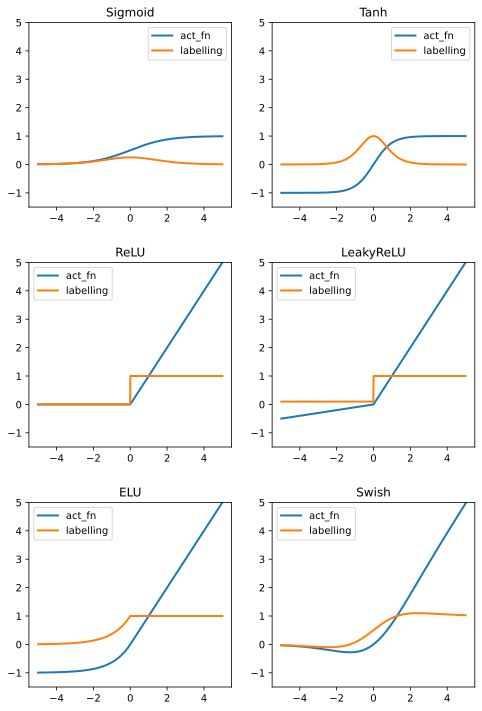

In [18]:
def vis_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grad = get_grad(act_fn, x)
    x, y, y_grad = x.cpu().numpy(),y.cpu().numpy(), y_grad.cpu().numpy()
    ax.plot(x, y, linewidth = 2, label = "act_fn")
    ax.plot(x, y_grad, linewidth = 2, label = "labelling")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5,x.max())



## visualizing other activation values

act_fns =[act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)
rows = math.ceil(len(act_fns)/2)
fig,ax = plt.subplots(rows, 2, figsize =(8, rows * 4))
for i, act_fn in enumerate(act_fns):
    vis_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace = 0.3)
plt.show()
    

In [19]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_sizes = 3072, num_classes = 10, hidden_size = [284, 200, 156, 130]):
        super().__init__()


        layers = []
        layers_size = [input_sizes] + hidden_size
        for layers_index in range(1, len(layers_size)):
            layers += [nn.Linear(layers_size[layers_index-1],layers_size[layers_index]),act_fn]
        layers += [nn.Linear(layers_size[-1], num_classes)]
        self.layers = nn.Sequential(*layers)

        self.config = {"act_fn": act_fn.config, "input_sizes": input_sizes, "num_classes": num_classes, "hidden_size": hidden_size} 
        

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.layers(x)
        return out

In [20]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")


def load_model(model_path, model_name, net = None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Are you sure all your files are listed here in the directory   \"{config_file}.\" Are you sure you saved the model in this directory?"
    assert os.path.isfile(model_file), f"Are you dure all your models are listed here in this model file  \"{model_file}.\" Are ypu sure you saved the model in ths model file?"


    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn = act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location = device))
    return net

def save_model(model, model_path, model_name):


    config_dict = model.config
    os.makedirs(model_path, exist_ok = True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
        torch.save(model.state_dict(), model_file)
    

In [21]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.
    
    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net
    
def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.
    
    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [22]:
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
data_point = "./data"

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(
                                    mean = (0.5, 0.5, 0.5),
                                    std = (0.5, 0.5, 0.5))
                               ])
train_datasets = CIFAR10(root = data_point, train = True, transform = transform, download = True)
train_set, val_set = torch.utils.data.random_split(train_datasets, [40000, 10000])

test_set = CIFAR10(root = data_point, train = False, transform = transform, download = True)

train_loader = data.DataLoader(train_set, batch_size = 1024, shuffle = True, drop_last = False)
val_loader = data.DataLoader(val_set, batch_size = 1024, shuffle = True, drop_last = False)
test_loader = data.DataLoader(test_set, batch_size = 1024, shuffle = True, drop_last = False)



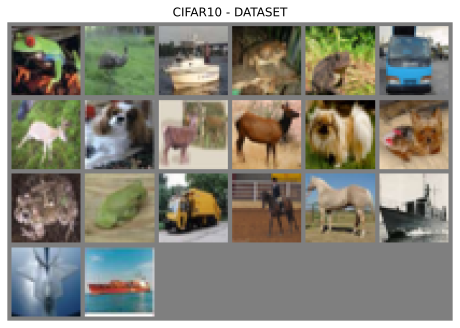

In [23]:
examples_image = [train_set[i][0] for i in range(20)]
img_grid = torchvision.utils.make_grid(torch.stack(examples_image, dim = 0), nrow = 6, normalize = True, pad_value = 0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize = (8,8))
plt.title("CIFAR10 - DATASET")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()


In [24]:
import seaborn as sns
def visualisation_grad(net, color = "CO"):

    net.eval()

    small_loader = data.DataLoader(train_set, shuffle = False, batch_size = 256)
    imgs, label = next(iter(small_loader))
    imgs, label = imgs.to(device), label.to(device)

    net.zero_grad()
    pred = net(imgs)
    loss = F.cross_entropy(pred, label)
    loss.backward()

    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()


    ## plotting
    columns = len(grads)
    fig, ax =  plt.subplots(1, columns ,figsize = (columns * 3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data = grads[key], bins=30, kde = True, color = color, ax = key_ax)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad Magnitude")
        fig_index += 1


    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
     
    
    
    

In [25]:
import inspect
print(inspect.signature(BaseNetwork))


(act_fn, input_sizes=3072, num_classes=10, hidden_size=[284, 200, 156, 130])


In [26]:
def train_model(net, model_name, num_epochs=50, patience=7, batch_size=1024, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(check_point, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss() 
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        import tqdm

        val_scores = []
        best_val_epoch = -1
        for epoch in range(num_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm.tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net,check_point, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()
    
    load_model(check_point,model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc
    

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

In [27]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"CIFAR10_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 49.06% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 51.54% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 51.96% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 51.84% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 48.60% ==============



In [28]:
print(type(train_loader))
print(type(act_fn_by_name[act_fn_name]))


<class 'torch.utils.data.dataloader.DataLoader'>
<class 'type'>


In [29]:
def visualisation(net, color = "CO"):
    activations = {}

    net.eval()

    small_loader = data.DataLoader(train_set, batch_size = 1203)
    imgs, label = next(iter(small_loader))
    with torch.no_grad():
         layer_index = 0
         imgs = imgs.to(device)
         imgs = imgs.view(imgs.size(0), -1)
         for layer_indexs, layer in enumerate(net.layers[:,1]):
             imgs = layer(imgs)
             activations[layer_indexs] = imgs.view(-1).cpu().numpy()


    ## visualizing
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize = (columns*2.9, rows* 2.8))
    fig_index = 0
    for key in activations:
        key_index = [fig_index//columns][fig_index%columns]
        sns.histplot(data = activations[key], ax = key_index, color=color, bins = 50, kde = True , state = "density")
        key_index.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close() 
    
    
    